# The FLAIR study
This notebook tries provides details on the structure of the flair dataset and makes suggestions how to process the data.

**Title**: A Crossover Study Comparing Two Automated Insulin Delivery System
Algorithms (PID vs. PID + Fuzzy Logic) in Individuals with Type 1
Diabetes (FLAIR- Fuzzy Logic Automated Insulin Regulation)

**Description**: A randomized crossover trial will compare the efficacy and safety of an
automated insulin delivery (AID) system with a proportional-integral-
derivative (PID) algorithm versus an automatic insulin delivery (AID) system
with a PID algorithm enhanced with a Fuzzy Logic algorithm.
    
**Devices**: The Minimed 670G 4.0 Advanced Hybrid Closed-Loop (AHCL) (PID +
Fuzzy Logic) pump with the Guardian Sensor (3) continuous glucose
monitoring sensor.


## Data Description:
The study data folder is named **FLAIRPublicDataSet**
From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **FLAIRDeviceCGM.txt**: List of CGM data downloaded
* **FLAIRDevicePump.txt**: List of pump data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Medtronic pump events and the guardian cgm. The glossary provides information about each column. While there are many columns, the following were identified as relevant.

**FLAIRDeviceCGM**:

* **PtID**: Patient ID
* **DataDtTm**: Date-time of sensor glucose reading
* **CGM**: Sensor glucose aka CGM - mdDl or mmol/L
* **DataDtTm_adjusted**: Adjusted value of DataDtTm 

**FLAIRDevicePump**:

* **PtID**: Patient ID
* **DataDtTm**: Date-time of pump data
* **NewDeviceDtTm**: The new date and time if this was changed in the device
* **BolusType**: Bolus type - The bolus insulin delivery type [Normal, Square, Dual (normal part), or Dual (square part)]
* **BolusDeliv**: Bolus volume delivered (U) - The number of insulin units actually delivered during the bolus insulin delivery
* **ExtendBolusDuration**: Duration of the square portion of either a square bolus or a dual wave bolus
* **BasalRt**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
* **BasalRtUnKnown**: Basal rate unknown as marked in the carelink file
* **TempBasalAmt**: Temp basal amount - If a temp basal was applied on the pump, this value is the temp basal amount
* **TempBasalType**: Temp basal type - The type of temporary basal adjustment (insulin rate or percent of basal)
* **TempBasalDur**: Temp basal duration (h:mm:ss) - The length of time for the temporary basal insulin delivery
* **Suspend**: State "Suspend" when the pump is suspended and "Resumed" when the pump is resumed 

**Questions**: 
* Do we need to track DataDtTm_adjusted or can we rely on DataDtTm?
* How often do NewDeviceDtTm** events happen and do we need to account fo these or is DataDtTm sufficient?
* How often do BasalRtUnKnown** events happen and how should we handle these?
* Are TempBasalAmt reflected in the BasalRt? Is the value a rate (U/h) or depend on the TempBasalType (Percent/Rate)?
* Do we have to keep track of temporary basal durations events (TempBasalDur) or do we get a normal basal rate at the end of the basal rate?
* How do we know if the temp basal rate is ended earlier than programmed
* How often does the pump suspend (Suspend)? Should we stop counting basal rates in this time?
* Do suspend events stop bolus deliveries? Do we need to account for it?

## Loading the data

In [1]:
import os, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
current_dir = os.getcwd(); 

<div class="alert alert-block alert-warning">
<b>Date Time Strings</b> There are date time strings without time component. We treat those without as midnight (00AM).
</div>

In [2]:
def parse_flair_dates(dates):
    """Parse date strings separately for those with/without time component, interpret those without as midnight (00AM)
        Args:
            df (pandas DataFrame): data frame holding data
            date_column (string): column name that holds date time strings to be used for parsing

        Returns:
            pandas series: with parsed dates
        """
    #make sure to only parse dates if the value is not null
    only_date = dates.apply(len) <=10
    dates_copy = dates.copy()
    dates_copy.loc[only_date] = pd.to_datetime(dates.loc[only_date], format='%m/%d/%Y')
    dates_copy.loc[~only_date] = pd.to_datetime(dates.loc[~only_date], format='%m/%d/%Y %I:%M:%S %p')
    return dates_copy

def load_data(file_name, columns):
    path = os.path.join(current_dir, '..', '..', 'data/raw', 'FLAIRPublicDataSet', 'Data Tables', file_name)
    df = pd.read_csv(path, sep="|", low_memory=False, usecols=columns)
    df['DateTime'] = df.loc[df.DataDtTm.notna(),'DataDtTm'].transform(parse_flair_dates)
    df['DateTimeAdjusted'] = df.loc[df.DataDtTm_adjusted.notna(),'DataDtTm_adjusted'].transform(parse_flair_dates)
    return df

df_cgm = load_data('FLAIRDeviceCGM.txt', columns=['PtID', 'DataDtTm', 'DataDtTm_adjusted', 'CGM'])
df_insulin = load_data('FLAIRDevicePump.txt', columns=['PtID', 'DataDtTm', 'DataDtTm_adjusted', 'BasalRt', 
                                                       'TempBasalAmt','TempBasalType', 'TempBasalDur','BolusType', 
                                                       'BolusSource', 'BolusDeliv', 'BolusSelected', 'ExtendBolusDuration', 'BasalRtUnKnown', 
                                                       'Suspend','PrimeVolumeDeliv','Rewind'])
display(df_cgm.head(2))
display(df_cgm.loc[df_cgm.DataDtTm_adjusted.notna()].head(2))
display(df_insulin.head(2))

,PtID,DataDtTm,CGM,DataDtTm_adjusted,DateTime,DateTimeAdjusted
0,26,5/15/2019 9:18:15 PM,136,NaN,2019-05-15 21:18:15,NaN
1,26,5/15/2019 9:13:15 PM,146,NaN,2019-05-15 21:13:15,NaN


,PtID,DataDtTm,CGM,DataDtTm_adjusted,DateTime,DateTimeAdjusted
1121607,108,10/28/2018 11:14:27 AM,148,10/24/2018 11:14:27 AM,2018-10-28 11:14:27,2018-10-24 11:14:27
1121609,108,10/28/2018 11:09:27 AM,144,10/24/2018 11:09:27 AM,2018-10-28 11:09:27,2018-10-24 11:09:27


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusSelected,BolusDeliv,ExtendBolusDuration,PrimeVolumeDeliv,Suspend,Rewind,BolusSource,DataDtTm_adjusted,DateTime,DateTimeAdjusted
0,26,5/15/2019 11:59:59 PM,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-15 23:59:59,NaN
1,26,5/15/2019 11:58:26 PM,NaN,False,NaN,NaN,NaN,Normal,0.025,0.025,NaN,NaN,NaN,NaN,CL_MICRO_BOLUS,NaN,2019-05-15 23:58:26,NaN


## Data Description

In [69]:
print(f"There are {len(df_insulin.PtID.unique())} unique patient ids in insulin data and {len(df_cgm.PtID.unique())} in cgm data")

print("CGM counts:")
print(df_cgm.count(),"\n");

print("Insulin counts:")
print(df_insulin.count(),"\n")

There are 115 unique patient ids in insulin data and 113 in cgm data
CGM counts:
PtID                 5508985
DataDtTm             5508985
CGM                  5508985
DataDtTm_adjusted      10655
DateTime             5508985
DateTimeAdjusted       10655
dtype: int64 

Insulin counts:
PtID                   5100621
DataDtTm               5100621
BasalRt                  60668
BasalRtUnKnown         5100621
TempBasalAmt              1446
TempBasalType             1446
TempBasalDur              1446
BolusType              3946622
BolusSelected          3940693
BolusDeliv             3555501
ExtendBolusDuration        445
PrimeVolumeDeliv         20363
Suspend                  72424
Rewind                    8938
BolusSource            3940446
DataDtTm_adjusted            0
DateTime               5100621
DateTimeAdjusted             0
AbsoluteBasal            60677
dtype: int64 



<div class="alert alert-block alert-warning"> <b>Temp Basal:</b> We have 1446 temp basal values. only 9 of these are set by insulin rate, the others are in percent.</div>

<div class="alert alert-block alert-warning"> <b>Suspend:</b> We have 72424 suspend events. These need to be factored in.</div>

<div class="alert alert-block alert-warning"> <b>Date Adjustments:</b> There are many adjusted datetime events for CGM (none for Insulin). We need to understand how to factor them in./</div>

# Adjusted DateTimes
We see that there are ~10k adjusted datetimes (~0.2% of the data).  Let's investigate.

In [4]:
subFrame = df_cgm.loc[df_cgm.DateTimeAdjusted.notnull()]
adjustmentInterval = subFrame.DateTime - subFrame.DateTimeAdjusted
print("Adjustment intervals and counts:")
display(adjustmentInterval.value_counts())

#how many users are there with adjusted datetimes?
print(f"{len(subFrame.PtID.unique())} users have adjusted datetimes: {subFrame.PtID.unique()}")
del subFrame, adjustmentInterval

Adjustment intervals and counts:


-6 days     5542
4 days      3862
-89 days    1251
dtype: int64

3 users have adjusted datetimes: [108  40  98]


<div class="alert alert-block alert-info"> Only 3 users have time adjusted data. The time shifts are significant (many days).</div>

Let's investigate these:

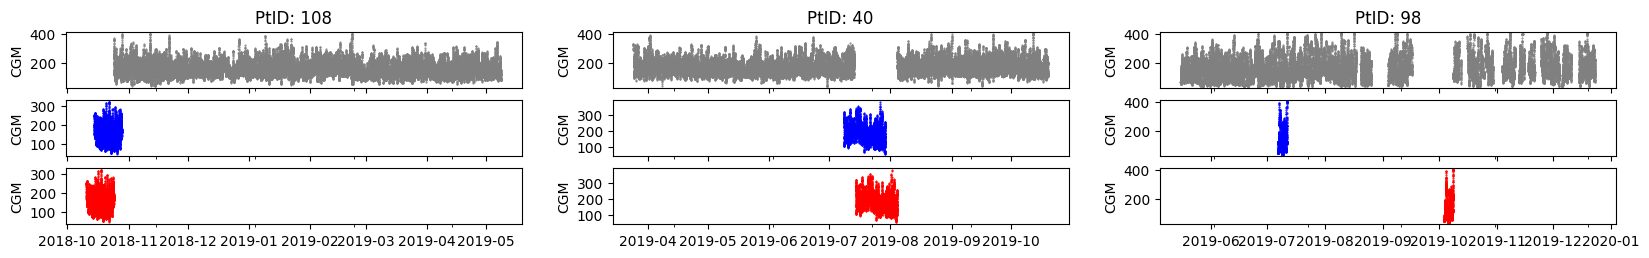

In [5]:
#Plot the cgm data for the three patients
f,AX = plt.subplots(3,3,figsize=(20,2.5),sharex='col')
for i_patient, patient_id in enumerate(df_cgm.loc[df_cgm.DateTimeAdjusted.notnull()].PtID.unique()):
    temp = df_cgm.loc[df_cgm.PtID == patient_id]
    temp.loc[temp.DateTimeAdjusted.isnull()].plot.scatter(x='DateTime', y='CGM',s=1, marker='.',ax=AX[0,i_patient],color='gray')
    temp.loc[temp.DateTimeAdjusted.notnull()].plot.scatter(x='DateTime', y='CGM',s=1, marker='.',ax=AX[1,i_patient],color='blue')
    temp.loc[temp.DateTimeAdjusted.notnull()].plot.scatter(x='DateTimeAdjusted', y='CGM',s=1, marker='.',ax=AX[2,i_patient],color='red')
    AX[0][i_patient].set_title("PtID: "+str(patient_id)); 
    AX[2][i_patient].set_xlabel(''); 
    

<div class="alert alert-block alert-info"> For the same time, there are rows with and without adjusted times. This means that the adjusted times overlap other rows and the adjusted times move the data in the right spot. Let's check on this.</div>

Let's check if the adjudted cgm traces make sense

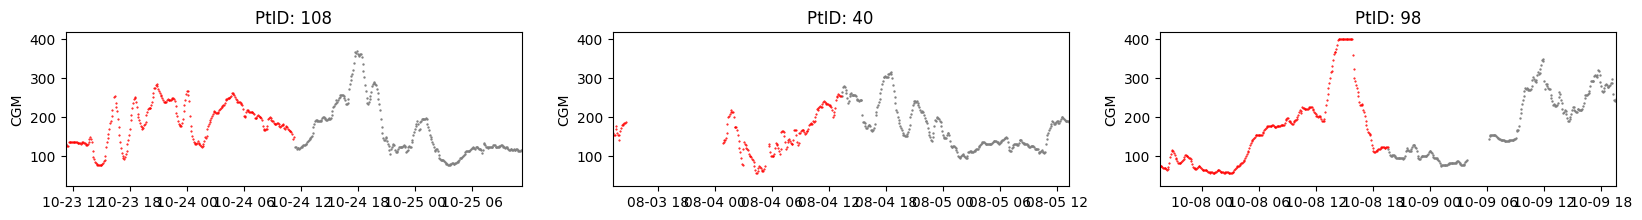

In [6]:
f,AX = plt.subplots(1,3,figsize=(20,2),sharex='col')
for i_patient, patient_id in enumerate(df_cgm.loc[df_cgm.DateTimeAdjusted.notnull()].PtID.unique()):
    temp = df_cgm.loc[df_cgm.PtID == patient_id]    
    
    ax = AX[i_patient]
    temp.loc[temp.DateTimeAdjusted.isnull()].plot.scatter(x='DateTime', y='CGM', s=2, marker='.', ax=ax, color='gray')
    temp.loc[temp.DateTimeAdjusted.notnull()].plot.scatter(x='DateTimeAdjusted', y='CGM', s=1, marker='.', ax=ax, color='red')
    
    #zoom in around adjustement datetime
    maxDate = temp.loc[temp.DateTimeAdjusted.notnull()].DateTimeAdjusted.max()
    ax.set_xlim((maxDate-pd.Timedelta(days=1),maxDate+pd.Timedelta(days=1)))
    ax.set_title("PtID: "+str(patient_id))
    ax.set_xlabel(None)

As we can see, the time adjusted CGM data falls in place nicely.
<div class="alert alert-block alert-warning">
<b>Date Adjustments:</b> We need to use the adjusted datetimes for cgm, when it exists.
</div>

# Understanding Basal Events
According to Lane, 100% refers to the normal basal rate. Medtronic allows setting temp basal percentages from 0 (shut off) to 200% (twice the basal rate). These values are confirmed by the histogram of the data. This is confirmed by the *Medtronic Manual* [1]:

**Temp basal rates:** "The duration of the temp basal rate can range from 30 minutes to 24 hours. After the temp basal rate delivery is completed or canceled, the programmed basal pattern resumes. The temp basal rates and preset temp basal rates can be defined using either a **percentage** of the current basal pattern or by setting a *specific rate*, as described [...]"

**Percent:** "Percent delivers a percentage of the basal rates programmed in the active basal pattern for the duration of the temp basal rate. The temp basal amount is rounded down to the next 0.025 units if the basal rate is set at less than 1 unit per hour, or to the next 0.05 units if the basal rate is set at more than 1 unit per hour. Temp basal rates can be set to deliver from *0% to 200%* of the scheduled basal rate. The *percentage used is based on the largest basal rate scheduled during the temp basal rate duration** and is **limited by the Max basal rate*."

**Rate**: "delivers a fixed basal insulin rate in *units per hour* for the duration of the temp basal rate. The amount set is *limited by the Max basal rate*"


[1] MiniMed-780G-system-user-guide-with-Guardian-4-sensor.pdf
[2] user_guide_minimed_670g_pump-skompresowany.pdf

<div class="alert alert-block alert-info"> We now want to understand how temporary basal rates need to be processed. We don;t know if these are already reflected in the basal rates. We also want to confirm that the Rate and Percent values are Let's investigate.</div>


Let's start by checking the event types

In [70]:
print("Temp basal types:",end='')
display(df_insulin.TempBasalType.value_counts())

print("BasalRtUnKnown:")
print(f"There are {df_insulin.BasalRtUnKnown.sum()} unknown basal rates, {len(df_insulin.PtID.unique())} patients are affected by this.")

Temp basal types:

Percent    1437
Rate          9
Name: TempBasalType, dtype: int64

BasalRtUnKnown:
There are 0 unknown basal rates, 115 patients are affected by this.


No unknown basals, good! Let's dig into Percent and Rate:

,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
16499,2019-03-11 12:46:39,NaN,100.0,Percent,0:00:00
29868,2019-03-10 23:59:21,NaN,50.0,Percent,12:00:00
29884,2019-03-10 15:43:56,NaN,0.0,Percent,8:15:00


,DateTime,BasalRt,TempBasalAmt,TempBasalType,TempBasalDur
58519,2019-06-24 11:47:55,NaN,0.1,Rate,0:01:00
498999,2019-05-17 08:04:58,NaN,1.6,Rate,0:49:00
500045,2019-05-06 11:44:36,NaN,1.3,Rate,1:30:00


There are 1437 TempBasalType=Percent and 9 TempBasalType=Rate


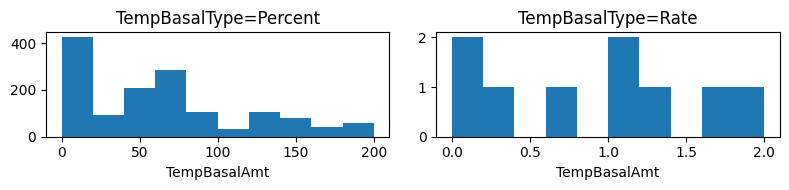

In [7]:
display(df_insulin.loc[df_insulin.TempBasalType =="Percent",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))
display(df_insulin.loc[df_insulin.TempBasalType =="Rate",['DateTime','BasalRt', 'TempBasalAmt','TempBasalType', 'TempBasalDur']].head(3))

fig, axs = plt.subplots(1,2, figsize=(8, 2))
axs[0].hist(df_insulin.loc[df_insulin.TempBasalType =="Percent",'TempBasalAmt'])
axs[0].set_title('TempBasalType=Percent'); axs[0].set_xlabel('TempBasalAmt')
axs[1].hist(df_insulin.loc[df_insulin.TempBasalType =="Rate",'TempBasalAmt'])
axs[1].set_title('TempBasalType=Rate'); axs[1].set_xlabel('TempBasalAmt')
plt.tight_layout()

numPercent = df_insulin.loc[df_insulin.TempBasalType =="Percent"].shape[0]
numRate = df_insulin.loc[df_insulin.TempBasalType == "Rate"].shape[0]
print(f"There are {numPercent} TempBasalType=Percent and {numRate} TempBasalType=Rate")

<div class="alert alert-block alert-info"> We have no unknown basal rates.</div>

<div class="alert alert-block alert-info">TempBasalAmt contains a percentage value if TempBasalType=='Percent' or a rate U/h if TempBasalType=='Rate'. </div>

<div class="alert alert-block alert-info"> The maximum basal temp basal rate programmed using the "Rate" feature only reached 2U/h. While higher temp basal rates can be programmed, only 9 such event mean that this feature was only used by a few users.</div>

<div class="alert alert-block alert-warning">
<b>Interpreting Temp Basal of 100 Percent:</b> The manual notices that *The percentage used is based on the largest basal rate scheduled during the temp basal rate duration*. So a value of 100% would change the basal rate to the highest standard basal rate, even if it occurs occurs within the duration of the temp basal rate.</div>

### Are temp basal rates reflected in the BasalRt?
The TempBasalAmt tells us how much the standard rate is changed. It is unclear weather these changes are already reflected in the BasalRt. Do figure this out, we check what happens to BasalRt when somebody uses a fixed basal rate, or a basal rate that is set to zero or 0%.

In [8]:
def parse_duration(duration_str):
  hours, minutes, seconds = map(int, duration_str.split(":"))
  return timedelta(hours=hours, minutes=minutes, seconds=seconds)

def drawBasal(ax, datetimes, rates, color='lightblue'):
    ax.stairs(rates[:-1],datetimes, label='basal rates',color=color,fill=True,alpha=1,edgecolor='blue')
    #add stems for the rates without marker,
    ax.stem(datetimes,rates,markerfmt=' ',basefmt=' ')
def drawInsulinEvents(df, b_draw_boluses=True, b_draw_basal=True, b_draw_temp_basal=True):
    f = plt.figure(figsize=(15,1.5))
    ax = f.gca();
    twinax=ax.twinx()
    plt.title(f"Patient {df.PtID.iloc[0]}")

    temp = df.copy()
    temp = temp.sort_values("DateTime")
    boluses = temp.dropna(subset=['BolusDeliv'],axis=0)
    basalRates = temp.dropna(subset=['BasalRt'],axis=0)
    tmpBasals = temp.dropna(subset=['TempBasalAmt'],axis=0)

    #boluses
    if (len(boluses) > 0) & b_draw_boluses:
        ax.bar(boluses.DateTime, boluses.BolusDeliv, width=timedelta(minutes=15), label='boluses')
        
    #basal rates
    if (len(basalRates) > 0) & b_draw_basal:
        drawBasal(ax,basalRates.DateTime,basalRates.BasalRt)
    
    if (len(tmpBasals) > 0) & b_draw_temp_basal:    
        colors = tmpBasals.apply(lambda x: 'yellow' if x.TempBasalType == 'Percent' else 'orange',axis=1)
        heights = tmpBasals.apply(lambda x: x.TempBasalAmt if  x.TempBasalType == 'Rate' else 2,axis=1)
        widths = tmpBasals.TempBasalDur.apply(parse_duration)
        ax.bar(tmpBasals.DateTime, 10, color=colors, width=widths, align='edge', label='temp basal amount', alpha=0.2, edgecolor='black')
        # add the temp basal amount as text above the bars
        for i, row in tmpBasals.iterrows():
            ax.text(row.DateTime+parse_duration(row.TempBasalDur)/2, 5, f"{row.TempBasalAmt} {row.TempBasalType}", fontsize=8,color='gray',rotation=90)
        
    
    ax.set_ylim([0,10]);
    ax.legend(loc='upper left')
    twinax.set_ylim([0,250])
    twinax.legend(loc="upper right")
    return ax

def selectRegionAroundEvent(df, patient_id, date_time, hours):
    sub_frame = df.loc[(df.PtID==patient_id) & (df.DateTime>date_time-timedelta(hours=hours)) & (df.DateTime<date_time+timedelta(hours=hours))]
    return sub_frame

No handles with labels found to put in legend.


,DateTime,BasalRt,TempBasalAmt,TempBasalDur,TempBasalType
4155927,2018-09-21 12:42:39,NaN,0.0,00:30:00,Percent
963186,2018-09-21 12:42:39,NaN,0.0,0:30:00,Percent
963135,2018-09-21 12:43:00,1.10,NaN,NaN,NaN
963131,2018-09-21 13:13:00,1.10,NaN,NaN,NaN
963125,2018-09-21 14:00:00,1.00,NaN,NaN,NaN
963059,2018-09-21 17:44:07,NaN,0.0,0:30:00,Percent
4155915,2018-09-21 17:44:07,NaN,0.0,00:30:00,Percent
963058,2018-09-21 17:45:00,1.00,NaN,NaN,NaN
963057,2018-09-21 18:15:00,1.00,NaN,NaN,NaN
963056,2018-09-21 18:30:50,NaN,0.0,0:30:00,Percent


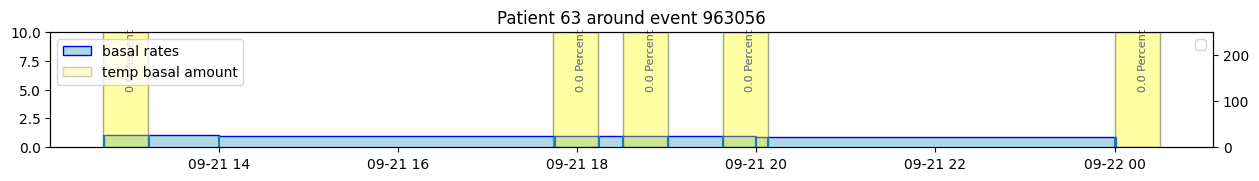

In [9]:
#Example with Percent = 0
#random_index = random.choice(df_insulin.loc[(df_insulin.TempBasalAmt==0 ) & (df_insulin.TempBasalType=="Percent")].index)
random_index = 963056 #for reproducibility
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 6)
drawInsulinEvents(subFrame, b_draw_boluses=False); 
plt.title(f"{plt.gca().get_title()} around event {random_index}")

subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 6)
subFrame = subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all')
display(subFrame.loc[:,['DateTime', 'BasalRt', 'TempBasalAmt','TempBasalDur','TempBasalType']].sort_values('DateTime',ascending=True))

No handles with labels found to put in legend.


,DateTime,BasalRt,TempBasalAmt,TempBasalDur,TempBasalType
688215,2019-03-30 00:00:00,1.05,NaN,NaN,NaN
688128,2019-03-30 14:39:40,NaN,0.0,0:17:00,Rate
688126,2019-03-30 14:57:00,1.05,NaN,NaN,NaN
688047,2019-03-30 23:03:11,NaN,50.0,4:00:00,Percent
688046,2019-03-30 23:04:00,1.05,NaN,NaN,NaN
687993,2019-03-31 00:00:00,1.05,NaN,NaN,NaN
687992,2019-03-31 03:04:00,1.05,NaN,NaN,NaN


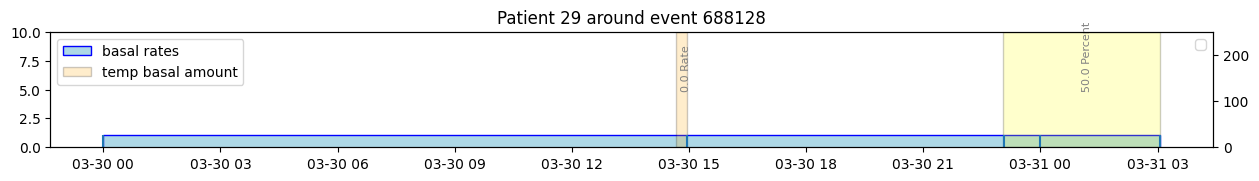

In [10]:
#Example with Rate = 0 
random_index = random.choice(df_insulin.loc[(df_insulin.TempBasalAmt==0 ) & (df_insulin.TempBasalType=="Rate")].index)
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 24)
drawInsulinEvents(subFrame, b_draw_boluses=False); 
plt.title(f"{plt.gca().get_title()} around event {random_index}")

subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 24)
subFrame = subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all')
display(subFrame.loc[:,['DateTime', 'BasalRt','TempBasalAmt','TempBasalDur','TempBasalType']].sort_values('DateTime',ascending=True))

No handles with labels found to put in legend.


,DateTime,BasalRt,TempBasalAmt,TempBasalDur,TempBasalType
825059,2019-04-07 00:00:00,1.0,NaN,NaN,NaN
824993,2019-04-07 02:00:00,1.1,NaN,NaN,NaN
824926,2019-04-07 03:23:36,NaN,150.0,0:30:00,Percent
824925,2019-04-07 03:24:00,1.1,NaN,NaN,NaN
824922,2019-04-07 03:54:00,1.1,NaN,NaN,NaN
824916,2019-04-07 08:00:00,1.5,NaN,NaN,NaN
824850,2019-04-07 09:38:48,NaN,130.0,0:26:00,Percent
824849,2019-04-07 09:39:00,1.5,NaN,NaN,NaN
824843,2019-04-07 10:00:00,1.4,NaN,NaN,NaN
824842,2019-04-07 10:05:00,1.4,NaN,NaN,NaN


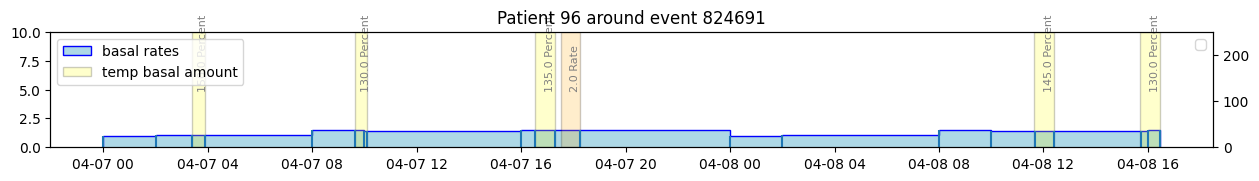

In [11]:
#Example with Rate/Percent = >0
random_index = 824691 #for reproducibility
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 24)
drawInsulinEvents(subFrame, b_draw_boluses=False); 
plt.title(f"{plt.gca().get_title()} around event {random_index}")
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[random_index,'PtID'], df_insulin.loc[random_index,'DateTime'], 24)
subFrame = subFrame.dropna(subset=['TempBasalAmt', 'BasalRt', 'TempBasalAmt', 'TempBasalDur'], how='all')
display(subFrame.loc[:,['DateTime', 'BasalRt','TempBasalAmt','TempBasalDur','TempBasalType']].sort_values('DateTime',ascending=True))

del random_index, subFrame

**For Percent events:**
* Temp basal events are *sometimes* reported twice (at least in this example). The duration format differs with leading 0 or two leading zeros for the hour (e.g. 0:30:00 vs. 00:30:00)
* When the temp basal starts and stops, BasalRt events are reported (~ one minute after) 
* However, the temp basal events are sometimes reported prior, sometimes after the BasalRt events
* During temp basal duration BasalRt events are still being reported

**For Rate Events:** The reporting for "Rate" events is slightly different. Temp basal rate is  
 * Basalrate is **not** reported shortly after the temp basal starts



## What we learned about basal rates
* Standard basal rates do not reflect temporary basal rate changes
* Temporary basal rates are either given as Percent (of the normal basal) or as Rate (replacing standard basal)
* During temp basal rates are active, Standard BasalRt events can change and are reported

**Percent**:

* Standard Basal rates are reported shortly after temp basal start and stop
* Temporary Basal Percent rates are reported **twice**, with the same timestamp but the duration format differs with leading 0 or without leading zeros for the hour (e.g. 00:15:00) vs.(0:15:00) 

**Rate:**
* There are only 9 cases where temporary basal is "Rate", in these cases, standard basal rate is not reported shortly after the temp basal rate *starts*
3. Temporary Basal Percent rates are reported **once**, without leading 0 for duration hour (0:15:00) 

**Takeaway:** 

To reconstruct true basal rates, we need to consider the TempBasalAmt and TempBasalType. We can use the BasalRt events as a basis and apply the TempBasalAmt for the duration of the TempBasalDur. Depending on the value of the TempBasalType, we either need to multiply the BasalRt by the TempBasalAmt (when TempBasalType is "Percent") or we can directly set the BasalRt to the TempBasalAmt (when TempBasalType is "rate"). 

To create the correct event history, we take advantage of the fact that basal rates are reported shortly after a Percent rate is set. Here, we simply multiply all basal rates within the temp basal duration period. After the temp basal duration, the standard basal rate is reported and automatically takes over. In the "Rate" case, we know that the standard basal rate is not reported shortly after the temp basal starts, so we need to treat the event as a new basal rate by copying the temp basal amount. While the temp basal Rate is set, standard basal rate changes should be ignored, we do this by setting all basal rates within the active duration to NaN (not 0!). As before, we take advantage of the fact that after the temp basal stops, a standard basal event is reported and automtaically takes over. 
    
<div class="alert alert-block alert-warning">
<b>Temp Basal Not Reflected in Basal Rate:</b> As we can see, the temporary Basal Events do not affect the basal rate. Therefore, we need to do post-processing to obtain the real basal rate
</div>

## Reconstructing True Basal Rates

In [12]:
import numpy as np
from datetime import timedelta
def calculate_absolute_basal(df):
    absolute_basal = df.BasalRt.copy().rename('AbsoluteBasal') #start with the Standard Basal Rates
    df_sub_temp_basals = df.loc[df.TempBasalAmt.notna()]
    df_sub_basals = df.loc[df.BasalRt.notna()]

    for index, row in df_sub_temp_basals.iterrows():
        #get basal events within temp basal active duration
        temp_basal_interval = pd.Interval(row.DateTime, row.DateTime + convert_duration_to_timedelta(row.TempBasalDur))
        affected_basal_indexes = df_sub_basals.index[df_sub_basals.DateTime.apply(lambda x: x in temp_basal_interval)]
        
        #multiply if Percent
        if row.TempBasalType == 'Percent':
            absolute_basal.loc[affected_basal_indexes] = df_sub_basals.BasalRt.loc[affected_basal_indexes]*row.TempBasalAmt/100
        #replace if Rate (set to NaN if Rate is set)
        else:
            absolute_basal.loc[index] = row.TempBasalAmt
            absolute_basal[affected_basal_indexes] = np.NaN
    return absolute_basal

def convert_duration_to_timedelta(duration):
    hours, minutes, seconds = map(int, duration.split(':'))
    return timedelta(hours=hours, minutes=minutes, seconds=seconds)

def drawAbsoluteBasalRates(datetimes, rate, ax):
    i_sorted = np.argsort(datetimes)
    ax.stairs(rate[i_sorted][:-1], datetimes[i_sorted],  hatch='//', label='true basal rate', edgecolor='black')


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


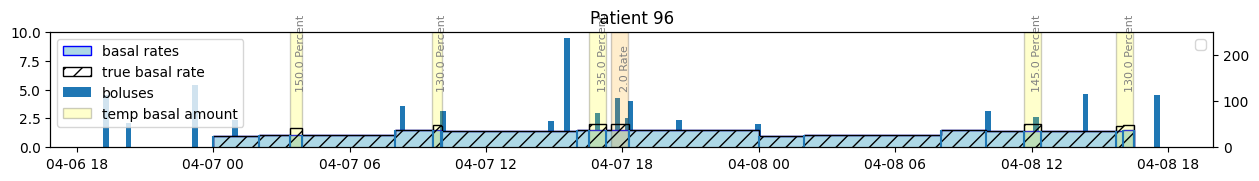

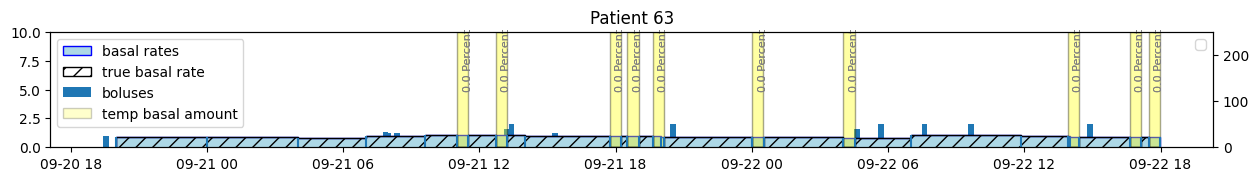

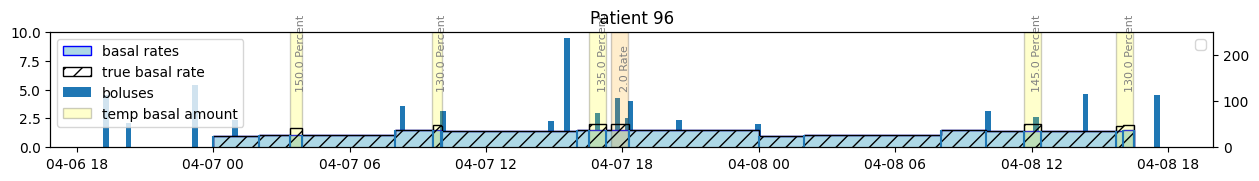

In [13]:
#for a single patient and region
index = 824691
subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[index,'PtID'], df_insulin.loc[index,'DateTime'], 24).copy()
subFrame = subFrame.sort_values('DateTime')
subFrame['AbsoluteBasal'] = calculate_absolute_basal(subFrame)
ax = drawInsulinEvents(subFrame)
drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values, subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values,ax)
ax.legend()


#for the whole dataset
absolute_basal = df_insulin.groupby('PtID').apply(calculate_absolute_basal)
absolute_basal = absolute_basal.reset_index(level=0,drop=True)
df_insulin['AbsoluteBasal'] = df_insulin.index.map(absolute_basal)
#two examples
for index in [963056,824691]:
    subFrame = selectRegionAroundEvent(df_insulin, df_insulin.loc[index,'PtID'], df_insulin.loc[index,'DateTime'], 24).copy()
    subFrame = subFrame.sort_values('DateTime')
    ax = drawInsulinEvents(subFrame)
    drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values,
                        subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values,ax)
    ax.legend()


## Suspend Events

Let's investigate suspend times: First, let's check if each start comes with an end-event. 

In [14]:
#compare suspend start and end event counts
counts = df_insulin.Suspend.value_counts()
display(counts)
print(f"There are {counts['NORMAL_PUMPING']} NORMAL_PUMPING events and {counts.drop('NORMAL_PUMPING').sum()} other Suspend events.")

#check for how many users the first suspend event is NORMAL_PUMPING
first_suspends = df_insulin.dropna(subset=['Suspend']).sort_values('DateTime').groupby('PtID').first()
first_insulin = df_insulin.sort_values('DateTime').groupby('PtID').first()
counts = first_suspends.Suspend.value_counts()
print(f"For {counts['NORMAL_PUMPING']} out of {counts.sum()} users, the first suspend event is a NORMAL_PUMPING event.\n")

#get the users whose first suspend is NORMAL_PUMPING
usersWithFirstSuspendIsNormalPumping = first_suspends.loc[first_suspends.Suspend=='NORMAL_PUMPING'].index
time_before_first_suspend = first_suspends.DateTime.loc[usersWithFirstSuspendIsNormalPumping]-first_insulin.DateTime.loc[usersWithFirstSuspendIsNormalPumping]
hours = time_before_first_suspend.dt.total_seconds()/(60*60)
print(f"Average time of data before NORMAL_PUMPING is {hours.mean():.1f} hours, maximum is {hours.max():.1f} hours.")


NORMAL_PUMPING                 36217
USER_SUSPEND                   14890
NOTSEATED_SUSPEND               9340
SmartGuard_PREDICTED_LOW_SG     5306
ALARM_SUSPEND                   4618
PLGM_PREDICTED_LOW_SG           1297
LOWSG_SUSPEND                    751
AUTO_SUSPEND                       5
Name: Suspend, dtype: int64

There are 36217 NORMAL_PUMPING events and 36207 other Suspend events.
For 89 out of 115 users, the first suspend event is a NORMAL_PUMPING event.

Average time of data before NORMAL_PUMPING is 0.2 hours, maximum is 10.9 hours.


<div class="alert alert-block alert-warning"> <b>End suspend without start:</b>  The very small difference is likely due to glucose suspend events that were started before the observation period. But this makes matching a little **more difficult**. We want to make sure we match the right pairs!</div>

<div class="alert alert-block alert-warning">
<b>Most users start with NORMAL_PUMPING:</b> For the majority of users we get a NORMAL_PUMPING event as the first Suspend event without a previous Suspend event. This could be because a) the pump was being set-up (e.g. catridge change etc.) and reported normal operation (to be verified) or b) there was a suspend event before the data collection started (unlikely because suspends are often short). 
</div>

<div class="alert alert-block alert-warning">
For those users whose first suspend event is a resume to normal pumping event, we don't know how long before the pump was suspended. The average time between the first insulin event and this resume event is roughly 0.25 hours. However, the maximum time is >10 hours.
</div>

We could check what kind of events happen before the first NORMAL_PUMPING event to calify what was happening.

In [15]:
#select the rows before the first NORMAL_PUMPING event
# Find the first "NORMAL_PUMPING" suspend event for each patient
first_suspend = df_insulin[df_insulin['Suspend'] == 'NORMAL_PUMPING'].groupby('PtID')['DateTime'].min()

# Create a new DataFrame where for each PtID, only rows before the first suspend event are included
df_filtered = pd.concat([df_insulin[(df_insulin['PtID'] == ptid) & (df_insulin['DateTime'] < suspend_time)] for ptid, suspend_time in first_suspend.items()])

#convert BasalRt	BasalRtUnKnown	TempBasalAmt	TempBasalType	TempBasalDur	BolusType	BolusDeliv	ExtendBolusDuration	PrimeVolumeDeliv	Suspend	Rewind	BolusSource	DataDtTm_adjusted to string array:
temp = df_filtered.dropna(subset=['BasalRt','TempBasalAmt','PrimeVolumeDeliv','Suspend','Rewind'],how='all').loc[:,['BasalRt','TempBasalAmt','PrimeVolumeDeliv','Suspend','Rewind']]
temp.count()

BasalRt             80
TempBasalAmt         2
PrimeVolumeDeliv    21
Suspend             26
Rewind              15
dtype: int64

<div class="alert alert-block alert-warning">It's unclear what is happening. Some rewind, some priming, some suspend events. </div>

### Suspend start and end times

,Suspend,DateTime,PreviousSuspend,DateTimePreviousSuspend
372962,NORMAL_PUMPING,2018-10-03 10:08:34,NaN,NaN
372958,NOTSEATED_SUSPEND,2018-10-03 10:46:49,NORMAL_PUMPING,2018-10-03 10:08:34
372954,NORMAL_PUMPING,2018-10-03 10:49:36,NOTSEATED_SUSPEND,2018-10-03 10:46:49
372953,USER_SUSPEND,2018-10-03 10:54:31,NORMAL_PUMPING,2018-10-03 10:49:36
372950,NORMAL_PUMPING,2018-10-03 11:07:55,USER_SUSPEND,2018-10-03 10:54:31


,Suspend,DateTime,PreviousSuspend,DateTimePreviousSuspend,Duration
372962,NORMAL_PUMPING,2018-10-03 10:08:34,NaN,NaN,NaT
372954,NORMAL_PUMPING,2018-10-03 10:49:36,NOTSEATED_SUSPEND,2018-10-03 10:46:49,0 days 00:02:47
372950,NORMAL_PUMPING,2018-10-03 11:07:55,USER_SUSPEND,2018-10-03 10:54:31,0 days 00:13:24
372845,NORMAL_PUMPING,2018-10-03 21:15:55,LOWSG_SUSPEND,2018-10-03 20:11:17,0 days 01:04:38
372807,NORMAL_PUMPING,2018-10-03 22:52:21,LOWSG_SUSPEND,2018-10-03 22:21:17,0 days 00:31:04


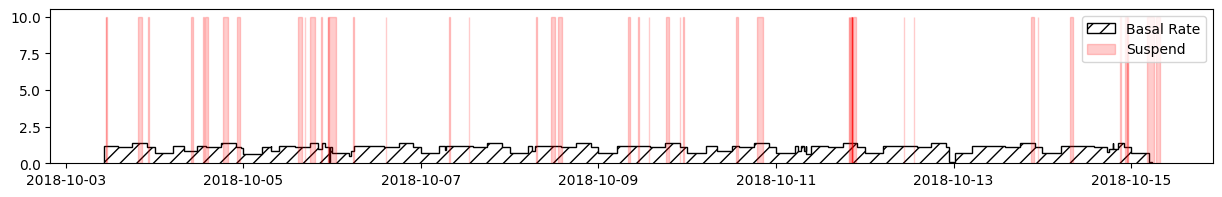

In [16]:
#get a user with>10 Suspend and Temporary Basal events
event_counts = df_insulin.groupby('PtID').agg({"Suspend":'count','TempBasalAmt':'count'})
users_with_temp_and_suspends = event_counts.loc[(event_counts.Suspend>10) & (event_counts.TempBasalAmt>10)]
random_user = random.choice(users_with_temp_and_suspends.index)

random_user = 69 #for repoducibility
subFrame = df_insulin.loc[df_insulin.PtID==69].copy()
subFrame = subFrame.sort_values('DateTime')

#reduce to first days
subFrame = subFrame.loc[subFrame.DateTime< subFrame.DateTime.min()+pd.Timedelta(days=12)]

#bring neighboring events side by side
suspend_times = subFrame.loc[subFrame.Suspend.notna(),['Suspend','DateTime']].sort_values('DateTime').copy()
suspend_times['PreviousSuspend'] = suspend_times.Suspend.shift(1)
suspend_times['DateTimePreviousSuspend'] = suspend_times.DateTime.shift(1)
display(suspend_times.head(5))

#get the sessions by selecting the rows that start with a suspend event and end with a normal pumping event
suspend_times = suspend_times.loc[(suspend_times.PreviousSuspend!='NORMAL_PUMPING') & (suspend_times.Suspend=='NORMAL_PUMPING')]
suspend_times['Duration'] = suspend_times.DateTime-suspend_times.DateTimePreviousSuspend
display(suspend_times.head(5))

suspend_times.Duration.describe()


#draw
#drop first row of suspend_times
suspend_times = suspend_times.iloc[1:]

#ax = drawInsulinEvents(subFrame, b_draw_boluses=False)
ax = plt.figure(figsize=(15,2)).gca()
drawAbsoluteBasalRates(subFrame.DateTime.loc[subFrame.AbsoluteBasal.notna()].values,
                       subFrame.AbsoluteBasal.loc[subFrame.AbsoluteBasal.notna()].values, ax)
ax.bar(suspend_times.DateTimePreviousSuspend, 10, width=suspend_times.Duration, alpha=0.2, edgecolor='red',color='red')
ax.legend(['Basal Rate','Suspend'],loc='upper right')  


### Suspend and Boluses

### Does medtronic suspend impact ongoing boluses?

**670g manual:**
I checked the manual and found no clear evidence
“SmartGuard suspend (Suspend before low and Suspend on low) features. SmartGuard suspend features can automatically stop and resume insulin delivery based on your SG values and low limit.”
:arrow_right: So both?
When a SmartGuard suspend event occurs, basal insulin delivery automatically resumes if your SG values are rising and have met the specified criteria,
:arrow_right: Oh, just basal?


**Medtronic FAQ:**
 I bolused for food I did not eat, will the system stop insulin delivery?
If the system sees that the sensor glucose is falling it will decrease the insulin being delivered and/or stop insulin from being delivered. However, it is important that you eat the amount of carbohydrates that you bolused for because the bolus insulin that you gave will already be working in your body.
:arrow_right: This indicates that boluses will in fact be stopped

Can you deliver a Dual Wave™ or Square Wave™ bolus in SmartGuard™ technology?
You cannot deliver a dual or square wave bolus in SmartGuard™ technology. The system is designed to compensate for a delayed rise in sensor glucose levels due to high fat, high carb meals. The auto basal adjustments every 5 minutes and auto corrections may eliminate the need for using the dual or squave wave bolus.
:arrow_right: So it might not even be relevant for us. Question remains what happens during a suspend while a standard bolus is ongoing.


**User Blog Post**
https://littlet1d.blogspot.com/2015/03/smartguard-dual-wave-bolus-cancellation.html
In this article from 2015 a user complains:
The message in the data file (not the pump screen) is the same as before:-
Suspend Before / At Low will suspend basal and cancel an extended bolus. 

The answer for us is the same: We need to manually go back in after basal has resumed and put in a revised Square Wave bolus if necessary.

Ok, I get it, but I’m still concerned: We know and understand that we need to think about manually inputting a revised Square Wave bolus following a Suspend before Low.

But - and this is, I think a big “but”, there’s no obvious warning / reminder message on Resume to prompt you (or whoever happens to be looking after Janki) to do this. There is an alarm in the pump log, but it doesn’t make it to the screen...
:arrow_right: At least in 2015 boluses seem to be cancelled and not resumed automatically, only basal resumes.

<div class="alert alert-block alert-info">It appears so as if all dual wave or square boluses are manual or bolus wizard boluses and are not executed in closed loop mode. This is consistent with the manual of the 670g where extended boluses are not available when smartguard is enabled.</div>

In [17]:
print("bolus amounts for closed loop boluses:")
display(df_insulin.loc[df_insulin.BolusSource.isin(['CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS', 'CLOSED_LOOP_FOOD_BOLUS', 'CL_BG_CORRECTION_N_FOOD_BOLUS', 'CL_FOOD_BOLUS']), ['BolusDeliv', 'BolusSelected']].sum())

print("bolus sources for Dual or Square boluses:")
display(df_insulin.loc[df_insulin.BolusType.str.contains('Dual|Square', na=False), 'BolusSource'].value_counts())

print("bolus amounts for Dual or Square boluses:")
display(df_insulin.loc[df_insulin.BolusType.str.contains('Dual|Square', na=False), ['BolusDeliv', 'BolusSelected']].sum())

bolus amounts for closed loop boluses:


BolusDeliv       425838.30
BolusSelected    861319.58
dtype: float64

bolus sources for Dual or Square boluses:


BOLUS_WIZARD    951
MANUAL           77
Name: BolusSource, dtype: int64

bolus amounts for Dual or Square boluses:


BolusDeliv       2590.63
BolusSelected    5132.08
dtype: float64

From the above we make the following assumptions:
<div class="alert alert-block alert-info">The smartguard feature automatically reduces boluses.</div>
<div class="alert alert-block alert-info">There are no unknown basal rates</div>
<div class="alert alert-block alert-info">It appears so as if all dual wave or square boluses are manual or bolus wizard boluses and are not executed in closed loop mode. This is consistent with the manual of the 670g where extended boluses are not available when smartguard is enabled.</div>

# Boluses:

* **Normal bolus**: provides a single immediate dose of insulin.
* **Square Wave bolus**: delivers a single bolus evenly over an extended period of time from 30 minutes up to 8 hours.
* **Dual Wave bolus**: delivers a combination of an immediate normal bo‐ lus followed by a Square Wave bolus.

<div>
<img src="Bolus Types Medtronic.png" width="500"/>
</div>

In [68]:
print("Bolus sources:",end='')
display(df_insulin.BolusSource.value_counts())

print("Bolus types:",end='')
display(df_insulin.BolusType.value_counts())

Bolus sources:

CLOSED_LOOP_MICRO_BOLUS                     2628112
CL_MICRO_BOLUS                               542076
CLOSED_LOOP_AUTO_BOLUS                       490478
BOLUS_WIZARD                                  96003
CLOSED_LOOP_BG_CORRECTION_AND_FOOD_BOLUS      84708
CLOSED_LOOP_FOOD_BOLUS                        46554
CL_BG_CORRECTION_N_FOOD_BOLUS                 17901
CLOSED_LOOP_BG_CORRECTION                     15482
CL_FOOD_BOLUS                                 11734
MANUAL                                         4240
CL_BG_CORRECTION                               3158
Name: BolusSource, dtype: int64

Bolus types:

Normal                3945345
Dual (square part)        697
Dual (normal part)        534
Square                     46
Name: BolusType, dtype: int64

<div class="alert alert-block alert-warning"> <b>Dual Wave Boluses:</b> There are (697 or 534) dual wave and 46 sqaure (extended) boluses (<0.02% of the boluses). The dual wave bolus events (square part) (normal part) should be equal in theory. But this could be because some boluses were stopped.</div>

## Under-delivered Boluses
Let's check if it is clear how much insulin was delivered for each part of the bolus
When a bolus was not fully delivered, the delivery duration is likely shorter, this is especially cruicial for extended boluses. Let's check if the data tells us
    

In [20]:
#give me some rows where the delivered bolus is not equal to the selected bolus
boluses = df_insulin.loc[df_insulin.BolusType.notna()]
boluses.loc[:,['BolusDeliv','BolusSelected']].agg(['sum','count'])

,BolusDeliv,BolusSelected
sum,1272434.995,2140506.345
count,3555478.000,3940647.000


* There are boluses that were selected but not delivered.
* There are some null values in BolusDeliv

In [25]:
display(boluses.loc[boluses.BolusDeliv.isna(),['BolusDeliv','BolusSelected']].head(2))
display(boluses.loc[boluses.BolusDeliv==0,['BolusDeliv','BolusSelected']].head(2))
display(boluses.loc[(boluses.BolusType == 'Dual (square part)') & (boluses.BolusDeliv<boluses.BolusSelected)].head())

,BolusDeliv,BolusSelected
41,NaN,4.5
48,NaN,0.4


,BolusDeliv,BolusSelected
9599,0.0,0.4
13257,0.0,0.1


,PtID,DataDtTm,BasalRt,BasalRtUnKnown,TempBasalAmt,TempBasalType,TempBasalDur,BolusType,BolusSelected,BolusDeliv,ExtendBolusDuration,PrimeVolumeDeliv,Suspend,Rewind,BolusSource,DataDtTm_adjusted,DateTime,DateTimeAdjusted,AbsoluteBasal
16723,26,3/7/2019 7:38:30 AM,NaN,False,NaN,NaN,NaN,Dual (square part),7.600,5.925,6:14:00,NaN,NaN,NaN,NaN,NaN,2019-03-07 07:38:30,NaN,NaN
17221,26,2/26/2019 2:16:54 PM,NaN,False,NaN,NaN,NaN,Dual (square part),9.600,4.525,3:46:00,NaN,NaN,NaN,NaN,NaN,2019-02-26 14:16:54,NaN,NaN
17407,26,2/23/2019 3:36:27 PM,NaN,False,NaN,NaN,NaN,Dual (square part),3.300,2.175,2:38:00,NaN,NaN,NaN,NaN,NaN,2019-02-23 15:36:27,NaN,NaN
56517,15,7/27/2019 7:27:38 PM,NaN,False,NaN,NaN,NaN,Dual (square part),1.825,0.975,0:48:00,NaN,NaN,NaN,NaN,NaN,2019-07-27 19:27:38,NaN,NaN
58118,15,7/3/2019 1:30:37 PM,NaN,False,NaN,NaN,NaN,Dual (square part),5.825,0.400,0:08:00,NaN,NaN,NaN,NaN,NaN,2019-07-03 13:30:37,NaN,NaN


In [65]:
extended_boluses = df_insulin.loc[df_insulin.BolusType.isin(['Square', 'Dual (square part)'])]
duration_underdeliv = extended_boluses.loc[extended_boluses.BolusDeliv<extended_boluses.BolusSelected]
#how many events are there?
print(f"There are {len(duration_underdeliv)} underdelivered extended boluses.")
#convert to minutes
#duration_underdeliv = duration_underdeliv.apply(lambda x: x.total_seconds()/60)
display(duration_underdeliv.loc[:, ['BolusType',"BolusDeliv",'BolusSelected','ExtendBolusDuration']].head(5))

duration_full = extended_boluses.loc[extended_boluses.BolusDeliv==extended_boluses.BolusSelected]
display(duration_full.loc[:, ['BolusType',"BolusDeliv",'BolusSelected','ExtendBolusDuration']].head(5))


There are 75 underdelivered extended boluses.


,BolusType,BolusDeliv,BolusSelected,ExtendBolusDuration
16723,Dual (square part),5.925,7.600,6:14:00
17221,Dual (square part),4.525,9.600,3:46:00
17407,Dual (square part),2.175,3.300,2:38:00
56517,Dual (square part),0.975,1.825,0:48:00
58118,Dual (square part),0.400,5.825,0:08:00


,BolusType,BolusDeliv,BolusSelected,ExtendBolusDuration
16448,Dual (square part),5.0,5.0,1:30:00
16626,Dual (square part),4.5,4.5,7:59:00
16641,Dual (square part),3.5,3.5,2:30:00
16675,Dual (square part),4.3,4.3,7:59:00
16750,Dual (square part),3.1,3.1,0:30:00


It looks like the durations for the underdelivered boluses are more "random", let's check:

In [66]:
display(duration_underdeliv.ExtendBolusDuration.apply(lambda x: x.split(':')[1][1]).value_counts())
display(duration_full.ExtendBolusDuration.apply(lambda x: x.split(':')[1][1]).value_counts())

4    13
8    12
3    11
6     9
1     9
0     7
7     4
9     4
5     3
2     3
Name: ExtendBolusDuration, dtype: int64

0    262
5     62
9     22
4      1
Name: ExtendBolusDuration, dtype: int64

<div class="alert alert-block alert-info">The under-delivered boluses have a duration that is different from the delivered boluses. We can therefore assume that the duration was changed to the time until the bolus has been delivered.</div>